We will first load and visualize the distribution in the Students finals dataset, by color-coding the Pass and Fail on the graph of Quizzes vs Labs.


Augmented dataset:
    Quizzes      Labs     Final
0  5.399343  5.272347  4.947538
0  5.604606  5.253169  4.771173
0  5.615843  5.453487  4.724105
0  5.408512  5.207316  4.724854
0  5.348392  4.917344  4.473016
Shape: (160, 3)


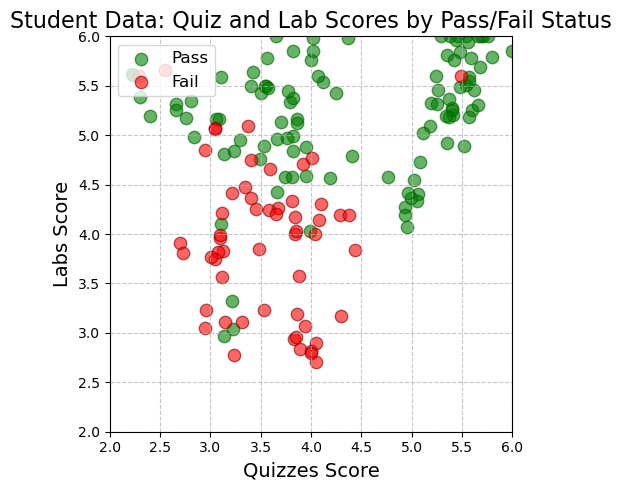

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Augmenting data by replicating and adding noise
np.random.seed(42)
augmented = []

for i in range(len(df)):
    row = df.iloc[i]
    for j in range(10):  # Create 10 variations of each record
        noise = np.random.normal(0, 0.2, 3)  # Add Gaussian noise
        new_row = row + noise
        new_row = new_row.clip(2, 6)  # Ensure values are within boundaries
        augmented.append(new_row)

# Create augmented DataFrame
df_aug = pd.DataFrame(augmented, columns=df.columns)
print("\nAugmented dataset:")
print(df_aug.head())
print(f"Shape: {df_aug.shape}")

# Create binary classification (Pass/Fail) 
# passing grade > 4.0 
def pass_fail(grade):
    return 1 if grade >= 4.0 else 0  # 1 = Pass, 0 = Fail

#  binary grades
df_aug['Pass'] = df_aug['Final'].apply(pass_fail)


# scatter plot with color-coded points
plt.figure(figsize=(5, 5))

#  pass/fail
pass_points = df_aug[df_aug['Pass'] == 1]
fail_points = df_aug[df_aug['Pass'] == 0]

plt.scatter(pass_points['Quizzes'], pass_points['Labs'], 
            color='green', label='Pass', alpha=0.6, s=80, edgecolor='darkgreen')
plt.scatter(fail_points['Quizzes'], fail_points['Labs'], 
            color='red', label='Fail', alpha=0.6, s=80, edgecolor='darkred')

plt.title('Student Data: Quiz and Lab Scores by Pass/Fail Status', fontsize=16)
plt.xlabel('Quizzes Score', fontsize=14)
plt.ylabel('Labs Score', fontsize=14)
plt.xlim([2, 6])
plt.ylim([2, 6])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig('raw_student_data.png', dpi=300, bbox_inches='tight')
plt.show()


We will now manually place a threshold, without any model, and see how the data samples are split.

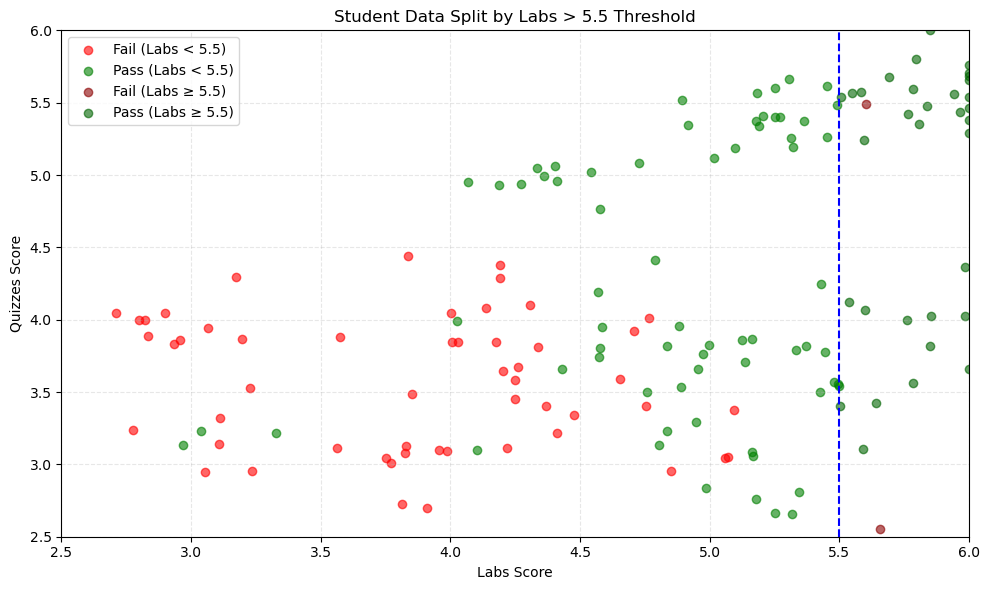

Total samples: 160
Samples with Labs < 5.5: 122
  Pass: 69, Fail: 53
Samples with Labs ≥ 5.5: 38
  Pass: 35, Fail: 3


In [2]:


# Create figure
plt.figure(figsize=(10, 6))

# Define threshold (you can change it, just don't forget to change the text in the legend and the title of the figure)
threshold = 5.5

# Split data by threshold
left_data = df_aug[df_aug['Labs'] < threshold]
right_data = df_aug[df_aug['Labs'] >= threshold]


plt.scatter(left_data[left_data['Pass'] == 0]['Labs'], left_data[left_data['Pass'] == 0]['Quizzes'], 
            color='red', label='Fail (Labs < 5.5)', alpha=0.6)
plt.scatter(left_data[left_data['Pass'] == 1]['Labs'], left_data[left_data['Pass'] == 1]['Quizzes'], 
            color='green', label='Pass (Labs < 5.5)', alpha=0.6)
plt.scatter(right_data[right_data['Pass'] == 0]['Labs'], right_data[right_data['Pass'] == 0]['Quizzes'], 
            color='darkred', label='Fail (Labs ≥ 5.5)', alpha=0.6)
plt.scatter(right_data[right_data['Pass'] == 1]['Labs'], right_data[right_data['Pass'] == 1]['Quizzes'], 
            color='darkgreen', label='Pass (Labs ≥ 5.5)', alpha=0.6)

# Add threshold line
plt.axvline(x=threshold, color='blue', linestyle='--', linewidth=1.5)

# Set labels and title
plt.xlabel('Labs Score')
plt.ylabel('Quizzes Score')
plt.title('Student Data Split by Labs > 5.5 Threshold') #here change the threshold value to correspond to the selected threshold


plt.xlim(2.5, 6)
plt.ylim(2.5, 6)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left')

# Save and show the plot
plt.tight_layout()
plt.savefig('simple_split.png', dpi=300)
plt.show()

# Print simple statistics about the split
print(f"Total samples: {len(df_aug)}")
print(f"Samples with Labs < {threshold}: {len(left_data)}")
print(f"  Pass: {sum(left_data['Pass'] == 1)}, Fail: {sum(left_data['Pass'] == 0)}")
print(f"Samples with Labs ≥ {threshold}: {len(right_data)}")
print(f"  Pass: {sum(right_data['Pass'] == 1)}, Fail: {sum(right_data['Pass'] == 0)}")

Still no model (no decision tree built). We will just calculate the splits for many different thresholds, and associate a Gini impurity to each threshold. We visulaize infomration gain, Gini impurity, and the data distribution (split) resulting by applying the best threshold (with "cleanest" split).

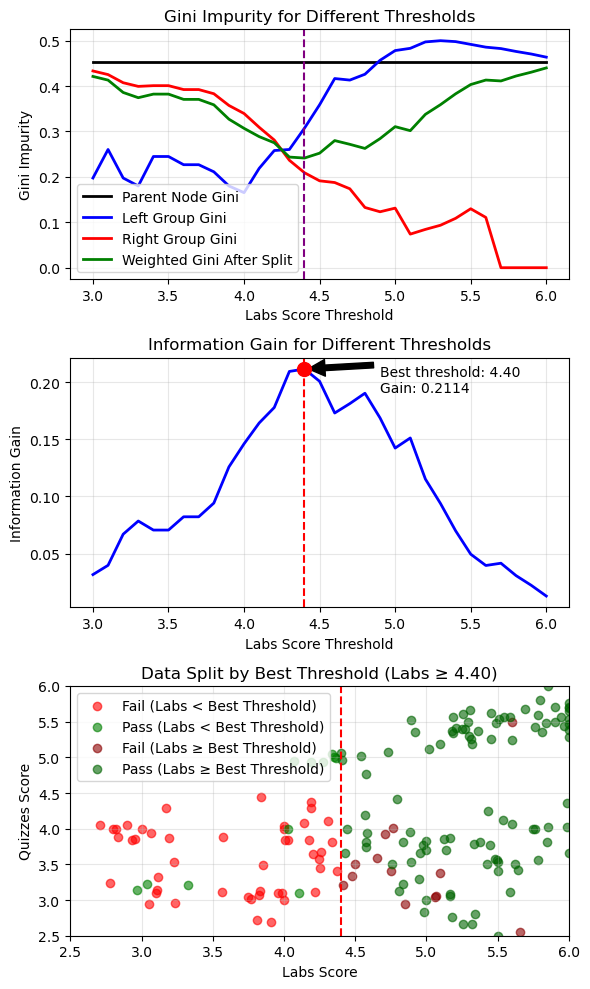

Best Threshold: Labs ≥ 4.40
  Information Gain: 0.2114

Gini Impurity:
  Parent Node: 0.4529
  Left Group (Labs < 4.40): 0.3074
  Right Group (Labs ≥ 4.40): 0.2091
  Weighted Gini After Split: 0.2415

Class Distribution:
  Left Group: 58 samples
    Pass: 11 (18.97%)
    Fail: 47 (81.03%)
  Right Group: 118 samples
    Pass: 104 (88.14%)
    Fail: 14 (11.86%)


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create pass/fail labels (1 for Pass, 0 for Fail)
df['Pass'] = df['Final'].apply(lambda x: 1 if x >= 4.0 else 0)

# Augment data by adding noise to create more points
np.random.seed(42)
augmented_data = []

for i, row in df.iterrows():
    # Add the original point
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final'],
        'Pass': row['Pass']
    })
    
    # Create 10 variations with noise
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        # Add noise and clip to range [2, 6]
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Determine pass/fail based on noisy final score
        new_pass = 1 if new_final >= 4.0 else 0
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final,
            'Pass': new_pass
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)

# Function to calculate Gini impurity and information gain
def calculate_gini(data, threshold):
    # Split the data
    left = data[data['Labs'] < threshold]
    right = data[data['Labs'] >= threshold]
    
    # Handle empty splits
    if len(left) == 0 or len(right) == 0:
        return {"parent_gini": 0, "left_gini": 0, "right_gini": 0, "weighted_gini": 0, "gain": 0}
    
    # Calculate proportions
    total = len(data)
    p_left = len(left) / total
    p_right = len(right) / total
    
    # Class proportions in parent
    p_fail = sum(data['Pass'] == 0) / total
    p_pass = sum(data['Pass'] == 1) / total
    parent_gini = 1 - (p_fail**2 + p_pass**2)
    
    # Class proportions in left group
    p_left_fail = sum(left['Pass'] == 0) / len(left)
    p_left_pass = sum(left['Pass'] == 1) / len(left)
    left_gini = 1 - (p_left_fail**2 + p_left_pass**2)
    
    # Class proportions in right group
    p_right_fail = sum(right['Pass'] == 0) / len(right)
    p_right_pass = sum(right['Pass'] == 1) / len(right)
    right_gini = 1 - (p_right_fail**2 + p_right_pass**2)
    
    # Weighted Gini impurity after split
    weighted_gini = p_left * left_gini + p_right * right_gini
    
    # Information gain
    gain = parent_gini - weighted_gini
    
    return {
        "parent_gini": parent_gini,
        "left_gini": left_gini,
        "right_gini": right_gini,
        "weighted_gini": weighted_gini,
        "gain": gain
    }

# Test different thresholds
thresholds = np.linspace(3.0, 6.0, 31)  # 31 thresholds from 3.0 to 6.0

# Calculate Gini impurity and gain for each threshold
results = []
for t in thresholds:
    gini_results = calculate_gini(df_aug, t)
    results.append(gini_results)
    
# Extract values from results
parent_ginis = [r["parent_gini"] for r in results]
left_ginis = [r["left_gini"] for r in results]
right_ginis = [r["right_gini"] for r in results]
weighted_ginis = [r["weighted_gini"] for r in results]
gains = [r["gain"] for r in results]

# Find the best threshold
best_idx = np.argmax(gains)
best_threshold = thresholds[best_idx]
best_gain = gains[best_idx]

# Create the plot
plt.figure(figsize=(6, 10))

# Plot 1: Gini impurity values for different thresholds
plt.subplot(3, 1, 1)
plt.plot(thresholds, parent_ginis, 'k-', label='Parent Node Gini', linewidth=2)
plt.plot(thresholds, left_ginis, 'b-', label='Left Group Gini', linewidth=2)
plt.plot(thresholds, right_ginis, 'r-', label='Right Group Gini', linewidth=2)
plt.plot(thresholds, weighted_ginis, 'g-', label='Weighted Gini After Split', linewidth=2)
plt.axvline(x=best_threshold, color='purple', linestyle='--', linewidth=1.5)
plt.xlabel('Labs Score Threshold')
plt.ylabel('Gini Impurity')
plt.title('Gini Impurity for Different Thresholds')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Information gain for different thresholds
plt.subplot(3, 1, 2)
plt.plot(thresholds, gains, 'b-', linewidth=2)
plt.scatter(best_threshold, best_gain, color='red', s=100, zorder=5)
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Labs Score Threshold')
plt.ylabel('Information Gain')
plt.title('Information Gain for Different Thresholds')
plt.grid(True, alpha=0.3)
plt.annotate(f'Best threshold: {best_threshold:.2f}\nGain: {best_gain:.4f}', 
             xy=(best_threshold, best_gain), xytext=(best_threshold+0.5, best_gain-0.02),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

# Plot 3: Data distribution with best threshold
plt.subplot(3, 1, 3)

# Split data by best threshold
left_data = df_aug[df_aug['Labs'] < best_threshold]
right_data = df_aug[df_aug['Labs'] >= best_threshold]

# Plots
plt.scatter(left_data[left_data['Pass'] == 0]['Labs'], left_data[left_data['Pass'] == 0]['Quizzes'], 
            color='red', label='Fail (Labs < Best Threshold)', alpha=0.6)
plt.scatter(left_data[left_data['Pass'] == 1]['Labs'], left_data[left_data['Pass'] == 1]['Quizzes'], 
            color='green', label='Pass (Labs < Best Threshold)', alpha=0.6)
plt.scatter(right_data[right_data['Pass'] == 0]['Labs'], right_data[right_data['Pass'] == 0]['Quizzes'], 
            color='darkred', label='Fail (Labs ≥ Best Threshold)', alpha=0.6)
plt.scatter(right_data[right_data['Pass'] == 1]['Labs'], right_data[right_data['Pass'] == 1]['Quizzes'], 
            color='darkgreen', label='Pass (Labs ≥ Best Threshold)', alpha=0.6)


plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Labs Score')
plt.ylabel('Quizzes Score')
plt.title(f'Data Split by Best Threshold (Labs ≥ {best_threshold:.2f})')
plt.xlim(2.5, 6)
plt.ylim(2.5, 6)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')


plt.tight_layout()
plt.savefig('threshold_with_gini.png', dpi=300)
plt.show()

# statistics for the best threshold
best_result = results[best_idx]
left = df_aug[df_aug['Labs'] < best_threshold]
right = df_aug[df_aug['Labs'] >= best_threshold]

print(f"Best Threshold: Labs ≥ {best_threshold:.2f}")
print(f"  Information Gain: {best_gain:.4f}")
print("\nGini Impurity:")
print(f"  Parent Node: {best_result['parent_gini']:.4f}")
print(f"  Left Group (Labs < {best_threshold:.2f}): {best_result['left_gini']:.4f}")
print(f"  Right Group (Labs ≥ {best_threshold:.2f}): {best_result['right_gini']:.4f}")
print(f"  Weighted Gini After Split: {best_result['weighted_gini']:.4f}")
print("\nClass Distribution:")
print(f"  Left Group: {len(left)} samples")
print(f"    Pass: {sum(left['Pass'] == 1)} ({sum(left['Pass'] == 1)/len(left):.2%})")
print(f"    Fail: {sum(left['Pass'] == 0)} ({sum(left['Pass'] == 0)/len(left):.2%})")
print(f"  Right Group: {len(right)} samples")
print(f"    Pass: {sum(right['Pass'] == 1)} ({sum(right['Pass'] == 1)/len(right):.2%})")
print(f"    Fail: {sum(right['Pass'] == 0)} ({sum(right['Pass'] == 0)/len(right):.2%})")

Finally, we build a decision tree, by "asking" several questions. In this case, the questions are: Is the data well split by some thresholds on the labs, then on the quizzes? The decision tree algorithm decieds which thresholds to select for the best possible splits. It also decides the order of splits, by ranking the resulting impurity and selecting the split with highest reduction in impurity first.

Original dataset class distribution:
Total: 16
Pass: 11 (68.75%)
Fail: 5 (31.25%)

Augmented dataset size: 176
Pass: 115 (65.34%)
Fail: 61 (34.66%)

Split at Labs = 4.5:
Total samples: 176
Samples with Labs < 4.5: 64
  Pass: 15, Fail: 49
Samples with Labs ≥ 4.5: 112
  Pass: 100, Fail: 12

Gini Impurity:
  Parent: 0.4529
  Left (Labs < 4.5): 0.3589
  Right (Labs ≥ 4.5): 0.1913
  Weighted Gini: 0.2523
  Information Gain: 0.2007


/Users/alisarupenyan/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(



Feature Importances:
  Quizzes: 0.2106
  Labs: 0.7894

Tree Structure:
Root feature: Labs
Root threshold: 4.3436


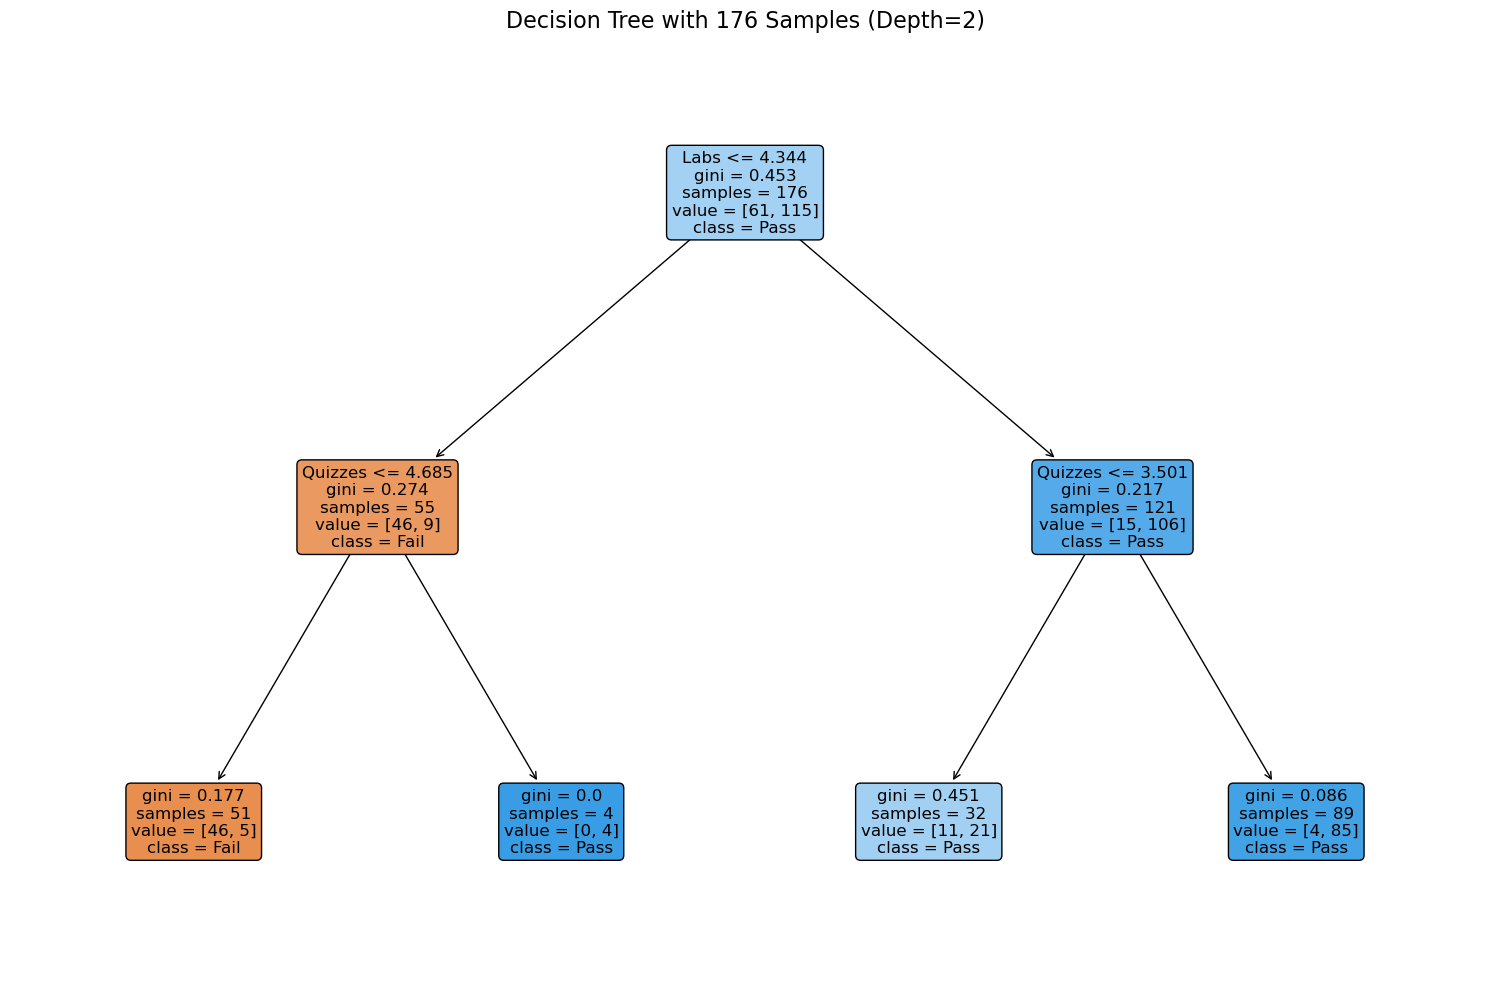

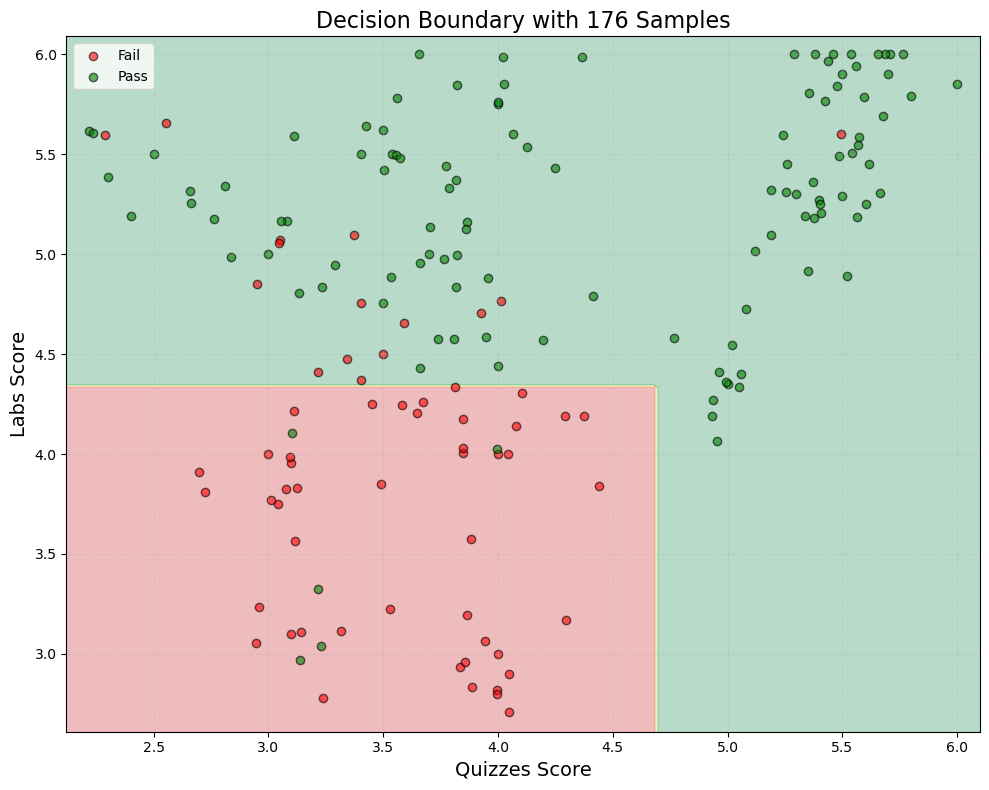

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create pass/fail labels (1 for Pass, 0 for Fail)
df['Pass'] = df['Final'].apply(lambda x: 1 if x >= 4.0 else 0)

# Print class distribution in original data
print("Original dataset class distribution:")
print(f"Total: {len(df)}")
print(f"Pass: {sum(df['Pass'] == 1)} ({sum(df['Pass'] == 1)/len(df):.2%})")
print(f"Fail: {sum(df['Pass'] == 0)} ({sum(df['Pass'] == 0)/len(df):.2%})")

# Augment data by adding noise to create more points
np.random.seed(42)
augmented_data = []

# First, add the original data points to keep total at 176
for i, row in df.iterrows():
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final'],
        'Pass': row['Pass']
    })

# Then add 10 variations with noise for each original point
for i, row in df.iterrows():
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        # Add noise and clip to range [2, 6]
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Determine pass/fail based on noisy final score
        new_pass = 1 if new_final >= 4.0 else 0
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final,
            'Pass': new_pass
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)

# Verify we have 176 samples
print(f"\nAugmented dataset size: {len(df_aug)}")
print(f"Pass: {sum(df_aug['Pass'] == 1)} ({sum(df_aug['Pass'] == 1)/len(df_aug):.2%})")
print(f"Fail: {sum(df_aug['Pass'] == 0)} ({sum(df_aug['Pass'] == 0)/len(df_aug):.2%})")

# Create a decision tree classifier
X = df_aug[['Quizzes', 'Labs']]
y = df_aug['Pass']

# With max_depth=2 to better visualize the tree
tree_model = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_model.fit(X, y)

# Evaluate splits at Labs = 4.5
labs_threshold = 4.5
left_group = df_aug[df_aug['Labs'] < labs_threshold]
right_group = df_aug[df_aug['Labs'] >= labs_threshold]

print(f"\nSplit at Labs = {labs_threshold}:")
print(f"Total samples: {len(df_aug)}")
print(f"Samples with Labs < {labs_threshold}: {len(left_group)}")
print(f"  Pass: {sum(left_group['Pass'] == 1)}, Fail: {sum(left_group['Pass'] == 0)}")
print(f"Samples with Labs ≥ {labs_threshold}: {len(right_group)}")
print(f"  Pass: {sum(right_group['Pass'] == 1)}, Fail: {sum(right_group['Pass'] == 0)}")

# Calculate Gini impurity for this split
def gini(data):
    if len(data) == 0:
        return 0
    
    p_pass = sum(data['Pass'] == 1) / len(data)
    p_fail = sum(data['Pass'] == 0) / len(data)
    return 1 - (p_pass**2 + p_fail**2)

parent_gini = gini(df_aug)
left_gini = gini(left_group)
right_gini = gini(right_group)

p_left = len(left_group) / len(df_aug)
p_right = len(right_group) / len(df_aug)

weighted_gini = p_left * left_gini + p_right * right_gini
information_gain = parent_gini - weighted_gini

print(f"\nGini Impurity:")
print(f"  Parent: {parent_gini:.4f}")
print(f"  Left (Labs < {labs_threshold}): {left_gini:.4f}")
print(f"  Right (Labs ≥ {labs_threshold}): {right_gini:.4f}")
print(f"  Weighted Gini: {weighted_gini:.4f}")
print(f"  Information Gain: {information_gain:.4f}")

# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(tree_model, filled=True, feature_names=['Quizzes', 'Labs'], 
          class_names=['Fail', 'Pass'], rounded=True, fontsize=12)
plt.title('Decision Tree with 176 Samples (Depth=2)', fontsize=16)
plt.tight_layout()
plt.savefig('decision_tree_176_samples.png', dpi=300)

# Also create a scatter plot showing the data and the decision boundary
plt.figure(figsize=(10, 8))

# Create a mesh grid to visualize the decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X['Quizzes'].min() - 0.1, X['Quizzes'].max() + 0.1
y_min, y_max = X['Labs'].min() - 0.1, X['Labs'].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Get the predicted class for each point in the mesh
Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')

# Plot the training points
plt.scatter(df_aug[df_aug['Pass'] == 0]['Quizzes'], df_aug[df_aug['Pass'] == 0]['Labs'], 
            color='red', label='Fail', alpha=0.6, edgecolor='k')
plt.scatter(df_aug[df_aug['Pass'] == 1]['Quizzes'], df_aug[df_aug['Pass'] == 1]['Labs'], 
            color='green', label='Pass', alpha=0.6, edgecolor='k')

plt.xlabel('Quizzes Score', fontsize=14)
plt.ylabel('Labs Score', fontsize=14)
plt.title('Decision Boundary with 176 Samples', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('decision_boundary_176_samples.png', dpi=300)

# Print the feature importances
print("\nFeature Importances:")
for i, feature in enumerate(['Quizzes', 'Labs']):
    print(f"  {feature}: {tree_model.feature_importances_[i]:.4f}")

# Analyze the tree structure
tree = tree_model.tree_
print("\nTree Structure:")
print(f"Root feature: {'Quizzes' if tree.feature[0] == 0 else 'Labs'}")
print(f"Root threshold: {tree.threshold[0]:.4f}")

Here we just visulaize weighted Gini impurity vs Information gain.

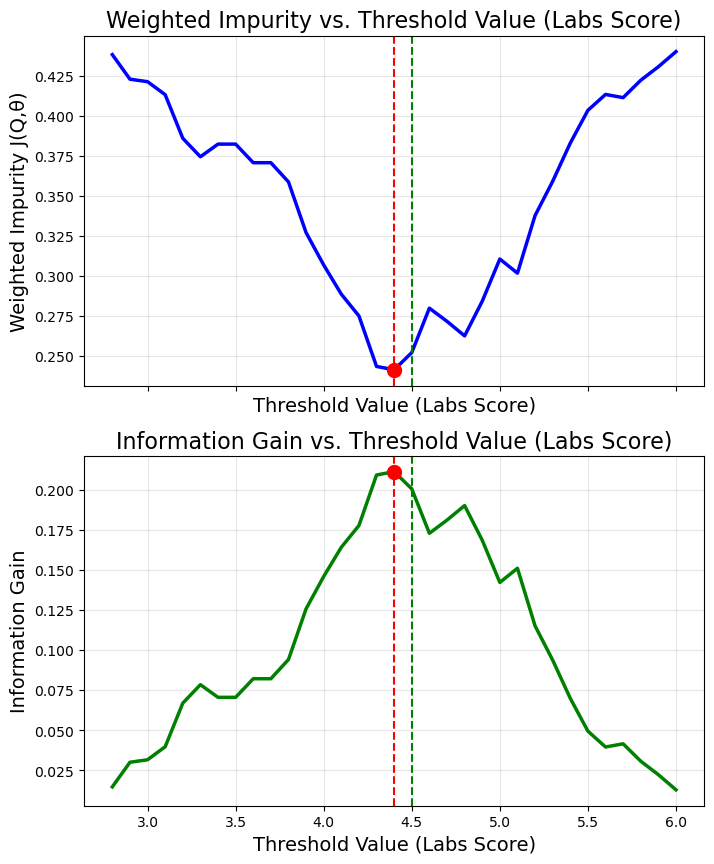

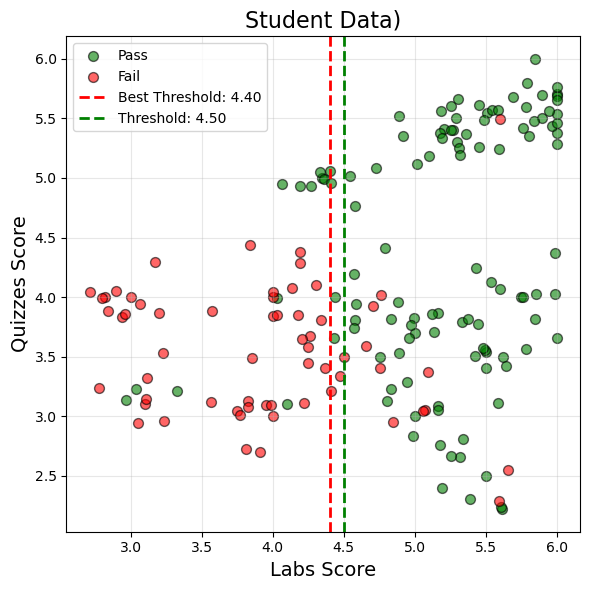

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create pass/fail labels (1 for Pass, 0 for Fail)
df['Pass'] = df['Final'].apply(lambda x: 1 if x >= 4.0 else 0)

# Augment data by adding noise to create more points
np.random.seed(42)
augmented_data = []

# First, include original data points
for i, row in df.iterrows():
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final'],
        'Pass': row['Pass']
    })

# Then add 10 variations with noise for each original point
for i, row in df.iterrows():
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        # Add noise and clip to range [2, 6]
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Determine pass/fail based on noisy final score
        new_pass = 1 if new_final >= 4.0 else 0
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final,
            'Pass': new_pass
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)



# Function to calculate Gini impurity
def gini_impurity(y):
    if len(y) == 0:
        return 0
    p1 = sum(y) / len(y)  # proportion of class 1 (Pass)
    p0 = 1 - p1  # proportion of class 0 (Fail)
    return 1 - (p1**2 + p0**2)

# Function to calculate weighted impurity and information gain for a threshold
def calculate_impurity_and_gain(data, feature, threshold):
    # Calculate parent impurity (before split)
    parent_impurity = gini_impurity(data['Pass'])
    
    # Split data based on threshold
    left = data[data[feature] < threshold]
    right = data[data[feature] >= threshold]
    
    # Skip if any group is empty
    if len(left) == 0 or len(right) == 0:
        return None, None, None, None
    
    # Calculate weighted impurity after split
    weight_left = len(left) / len(data)
    weight_right = len(right) / len(data)
    
    impurity_left = gini_impurity(left['Pass'])
    impurity_right = gini_impurity(right['Pass'])
    
    weighted_impurity = weight_left * impurity_left + weight_right * impurity_right
    
    # Calculate information gain
    information_gain = parent_impurity - weighted_impurity
    
    return weighted_impurity, information_gain, weight_left, weight_right

# Calculate weighted impurity and gain for different Lab thresholds
thresholds = np.linspace(2.5, 6.0, 36)  # Evaluate 36 thresholds from 2.5 to 6.0
results = []

for threshold in thresholds:
    imp, gain, w_left, w_right = calculate_impurity_and_gain(df_aug, 'Labs', threshold)
    if imp is not None:  # Skip thresholds that create empty splits
        results.append({
            'threshold': threshold,
            'weighted_impurity': imp,
            'information_gain': gain,
            'weight_left': w_left,
            'weight_right': w_right
        })

results_df = pd.DataFrame(results)

# best threshold (minimum weighted impurity / maximum information gain)
best_idx = results_df['weighted_impurity'].idxmin()
best_threshold = results_df.loc[best_idx, 'threshold']
best_impurity = results_df.loc[best_idx, 'weighted_impurity']
best_gain = results_df.loc[best_idx, 'information_gain']

# threshold vs weighted impurity and information gain
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot weighted impurity
ax1.plot(results_df['threshold'], results_df['weighted_impurity'], 'b-', linewidth=2.5)
ax1.scatter(best_threshold, best_impurity, color='red', s=100, zorder=5)
ax1.axvline(x=best_threshold, color='red', linestyle='--', linewidth=1.5)
ax1.axvline(x=4.5, color='green', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Weighted Impurity J(Q,θ)', fontsize=14)
ax1.set_title('Weighted Impurity vs. Threshold Value (Labs Score)', fontsize=16)
ax1.set_xlabel('Threshold Value (Labs Score)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot information gain
ax2.plot(results_df['threshold'], results_df['information_gain'], 'g-', linewidth=2.5)
ax2.scatter(best_threshold, best_gain, color='red', s=100, zorder=5)
ax2.axvline(x=best_threshold, color='red', linestyle='--', linewidth=1.5)
ax2.axvline(x=4.5, color='green', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Threshold Value (Labs Score)', fontsize=14)
ax2.set_ylabel('Information Gain', fontsize=14)
ax2.set_title('Information Gain vs. Threshold Value (Labs Score)', fontsize=16)
ax2.grid(True, alpha=0.3)
plt.savefig('threshold_weighted_impurity1.png', dpi=300, bbox_inches='tight')


# Create a visualization showing the distribution of passing and failing students by Labs score
plt.figure(figsize=(6, 6))

# Create a scatter plot
pass_students = df_aug[df_aug['Pass'] == 1]
fail_students = df_aug[df_aug['Pass'] == 0]

plt.scatter(pass_students['Labs'], pass_students['Quizzes'], 
            color='green', label='Pass', alpha=0.6, s=50, edgecolor='black')
plt.scatter(fail_students['Labs'], fail_students['Quizzes'], 
            color='red', label='Fail', alpha=0.6, s=50, edgecolor='black')

# Add vertical lines for the thresholds
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Best Threshold: {best_threshold:.2f}')
plt.axvline(x=4.5, color='green', linestyle='--', linewidth=2, 
            label='Threshold: 4.50')

# Add labels and title
plt.xlabel('Labs Score', fontsize=14)
plt.ylabel('Quizzes Score', fontsize=14)
plt.title('Student Data)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

# Calculate the number of samples on each side of the thresholds
best_left = len(df_aug[df_aug['Labs'] < best_threshold])
best_left_pass = len(df_aug[(df_aug['Labs'] < best_threshold) & (df_aug['Pass'] == 1)])
best_left_fail = len(df_aug[(df_aug['Labs'] < best_threshold) & (df_aug['Pass'] == 0)])
best_right = len(df_aug[df_aug['Labs'] >= best_threshold])
best_right_pass = len(df_aug[(df_aug['Labs'] >= best_threshold) & (df_aug['Pass'] == 1)])
best_right_fail = len(df_aug[(df_aug['Labs'] >= best_threshold) & (df_aug['Pass'] == 0)])

example_left = len(df_aug[df_aug['Labs'] < 4.5])
example_left_pass = len(df_aug[(df_aug['Labs'] < 4.5) & (df_aug['Pass'] == 1)])
example_left_fail = len(df_aug[(df_aug['Labs'] < 4.5) & (df_aug['Pass'] == 0)])
example_right = len(df_aug[df_aug['Labs'] >= 4.5])
example_right_pass = len(df_aug[(df_aug['Labs'] >= 4.5) & (df_aug['Pass'] == 1)])
example_right_fail = len(df_aug[(df_aug['Labs'] >= 4.5) & (df_aug['Pass'] == 0)])


# Show all plots
plt.tight_layout()
plt.savefig('threshold_weighted_impurity.png', dpi=300, bbox_inches='tight')
plt.show()

Now we will build a Regression tree with the same dataset. We will load it again to avoid mistakes.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Augment data by adding noise to create more points
np.random.seed(42)
augmented_data = []

# First, include original data points
for i, row in df.iterrows():
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final']
    })

# Then add 10 variations with noise for each original point
for i, row in df.iterrows():
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        # Add noise and clip to range [2, 6]
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)

Now, in the next cell we define the Mean Squared Error (MSE) which is the main metric to decide how a split should be done. This is different then in classification, where we used weighted Gini impurity, information gain, or entropy as metrics to decide where to split. We will just run different thresholds and show the one which results in smallest MSE.

In [12]:
# Function to calculate Mean Squared Error (MSE) for a split
def calculate_mse_for_split(data, feature, threshold):
    # Split data based on threshold
    left = data[data[feature] < threshold]
    right = data[data[feature] >= threshold]
    
    # Skip if any group is empty
    if len(left) == 0 or len(right) == 0:
        return float('inf'), None, None, None, None
    
    # Calculate mean values for each split
    left_mean = left['Final'].mean()
    right_mean = right['Final'].mean()
    
    # Calculate MSE for each split
    left_mse = ((left['Final'] - left_mean) ** 2).mean()
    right_mse = ((right['Final'] - right_mean) ** 2).mean()
    
    # Calculate weighted MSE
    total_samples = len(data)
    weighted_mse = (len(left) / total_samples) * left_mse + (len(right) / total_samples) * right_mse
    
    return weighted_mse, left_mean, right_mean, len(left), len(right)

# Calculate MSE reduction for various threshold values on Labs feature
thresholds = np.linspace(3.0, 5.5, 26)
mse_results = []

# Calculate parent MSE (before any split)
parent_mean = df_aug['Final'].mean()
parent_mse = ((df_aug['Final'] - parent_mean) ** 2).mean()

for threshold in thresholds:
    weighted_mse, left_mean, right_mean, left_count, right_count = calculate_mse_for_split(df_aug, 'Labs', threshold)
    if weighted_mse != float('inf'):
        mse_reduction = parent_mse - weighted_mse
        mse_results.append({
            'threshold': threshold,
            'weighted_mse': weighted_mse,
            'mse_reduction': mse_reduction,
            'left_mean': left_mean,
            'right_mean': right_mean,
            'left_count': left_count,
            'right_count': right_count
        })

mse_df = pd.DataFrame(mse_results)

# Find the best threshold (minimizes weighted MSE)
best_idx = mse_df['weighted_mse'].idxmin()
best_threshold = mse_df.loc[best_idx, 'threshold']
best_mse = mse_df.loc[best_idx, 'weighted_mse']
best_reduction = mse_df.loc[best_idx, 'mse_reduction']
best_left_mean = mse_df.loc[best_idx, 'left_mean']
best_right_mean = mse_df.loc[best_idx, 'right_mean']

print(f"\nParent node MSE: {parent_mse:.4f}")
print(f"Best threshold for Labs: {best_threshold:.2f}")
print(f"Weighted MSE after split: {best_mse:.4f}")
print(f"MSE reduction: {best_reduction:.4f}")
print(f"Left mean (Labs < {best_threshold:.2f}): {best_left_mean:.2f}")
print(f"Right mean (Labs ≥ {best_threshold:.2f}): {best_right_mean:.2f}")


Parent node MSE: 0.8347
Best threshold for Labs: 4.80
Weighted MSE after split: 0.4555
MSE reduction: 0.3792
Left mean (Labs < 4.80): 3.79
Right mean (Labs ≥ 4.80): 5.03


Finally, we build a regression model.


Tree MSE: 0.2320
Tree RMSE: 0.4817


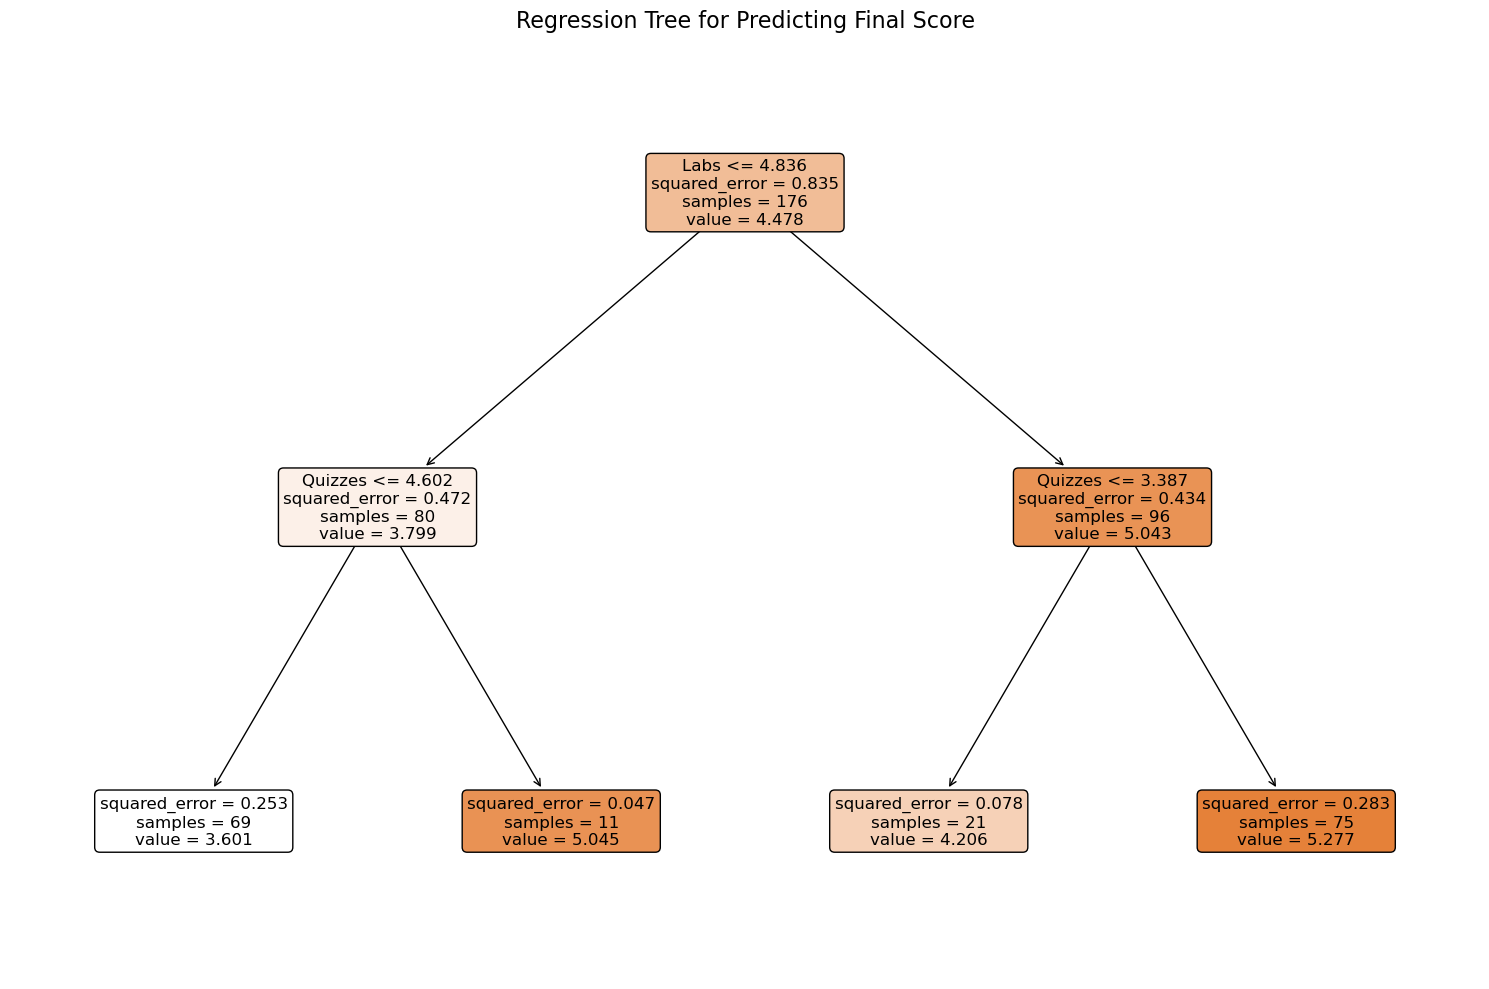

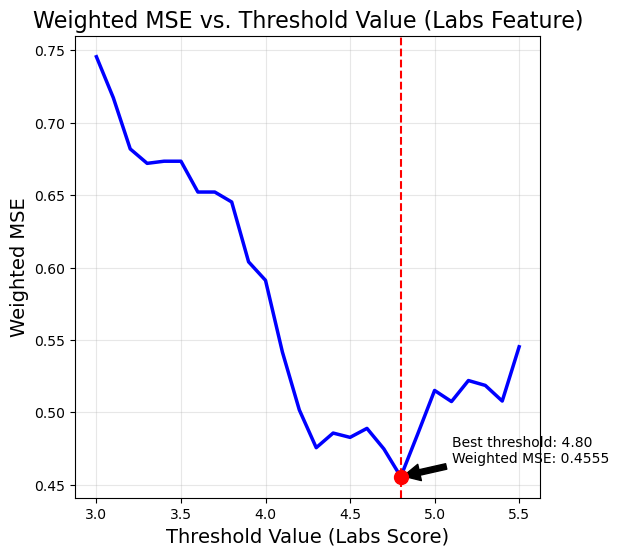

In [15]:
# Train a regression tree model
X = df_aug[['Quizzes', 'Labs']]
y = df_aug['Final']

# Create a regression tree with max_depth=2
regr_tree = DecisionTreeRegressor(max_depth=2, min_samples_split=10, random_state=42)
regr_tree.fit(X, y)

# Evaluate the model
train_predictions = regr_tree.predict(X)
mse = mean_squared_error(y, train_predictions)
rmse = np.sqrt(mse)
print(f"\nTree MSE: {mse:.4f}")
print(f"Tree RMSE: {rmse:.4f}")

# Create visualization of the regression tree
plt.figure(figsize=(15, 10))
plot_tree(regr_tree, filled=True, feature_names=['Quizzes', 'Labs'], rounded=True, fontsize=12)
plt.title('Regression Tree for Predicting Final Score', fontsize=16)
plt.tight_layout()
plt.savefig('regression_tree.png', dpi=300)

# Visualize the MSE reduction for different thresholds
plt.figure(figsize=(6, 6))
plt.plot(mse_df['threshold'], mse_df['weighted_mse'], 'b-', linewidth=2.5)
plt.scatter(best_threshold, best_mse, color='red', s=100, zorder=5)
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Threshold Value (Labs Score)', fontsize=14)
plt.ylabel('Weighted MSE', fontsize=14)
plt.title('Weighted MSE vs. Threshold Value (Labs Feature)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.annotate(f'Best threshold: {best_threshold:.2f}\nWeighted MSE: {best_mse:.4f}',
             xy=(best_threshold, best_mse), xytext=(best_threshold+0.3, best_mse+0.01),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)
plt.savefig('regression_mse_threshold.png', dpi=300)

Let's visualize the splits in the dataset.


Leaf Node Values (Predictions):
IF Labs <= 4.84 AND Quizzes <= 4.60 THEN Final = 3.60
IF Labs <= 4.84 AND Quizzes > 4.60 THEN Final = 5.05
IF Labs > 4.84 AND Quizzes <= 3.39 THEN Final = 4.21
IF Labs > 4.84 AND Quizzes > 3.39 THEN Final = 5.28


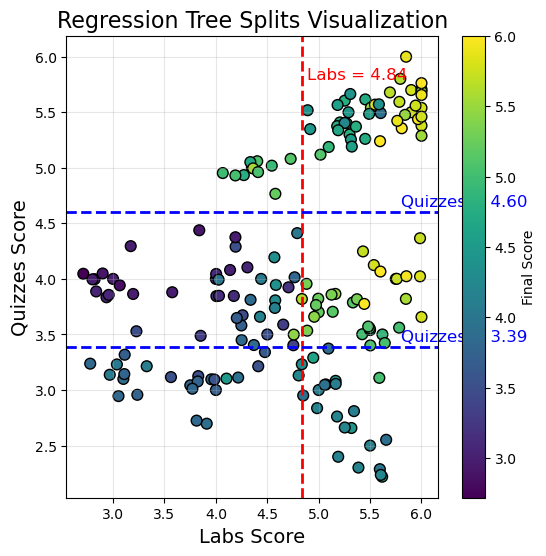

In [17]:
# visualization showing the splits 
plt.figure(figsize=(6, 6))

# Plot data points
sc = plt.scatter(X['Labs'], X['Quizzes'], c=y, cmap=plt.cm.viridis, s=60, edgecolor='k')

# Extract tree structure
n_nodes = regr_tree.tree_.node_count
children_left = regr_tree.tree_.children_left
children_right = regr_tree.tree_.children_right
feature = regr_tree.tree_.feature
threshold = regr_tree.tree_.threshold
value = regr_tree.tree_.value

# Get the splits
splits = []
for i in range(n_nodes):
    if children_left[i] != children_right[i]:  # Not a leaf node
        feat_idx = feature[i]
        if feat_idx == 0:  # Quizzes
            splits.append(('Quizzes', threshold[i], 'horizontal'))
        else:  # Labs
            splits.append(('Labs', threshold[i], 'vertical'))

# Draw the split lines
for feature_name, thresh, line_type in splits:
    if line_type == 'vertical':
        plt.axvline(x=thresh, color='red', linestyle='--', linewidth=2)
        plt.text(thresh+0.05, 5.8, f'Labs = {thresh:.2f}', fontsize=12, color='red')
    else:
        plt.axhline(y=thresh, color='blue', linestyle='--', linewidth=2)
        plt.text(5.8, thresh+0.05, f'Quizzes = {thresh:.2f}', fontsize=12, color='blue')

# Add labels and title
plt.xlabel('Labs Score', fontsize=14)
plt.ylabel('Quizzes Score', fontsize=14)
plt.title('Regression Tree Splits Visualization', fontsize=16)
plt.colorbar(sc, label='Final Score')
plt.grid(True, alpha=0.3)
plt.savefig('regression_tree_splits.png', dpi=300)

# Extract and display the leaf node values from the tree
def extract_leaf_node_values(tree):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    value = tree.tree_.value
    
    leaf_values = []
    
    def extract_leaves(node_id, path=[]):
        if children_left[node_id] == children_right[node_id]:  # Leaf node
            leaf_values.append((node_id, path, value[node_id][0][0]))
            return
        
        # Not a leaf node
        feature_name = ['Quizzes', 'Labs'][feature[node_id]]
        threshold_value = threshold[node_id]
        
        # Left path
        left_path = path + [(feature_name, '<=', threshold_value)]
        extract_leaves(children_left[node_id], left_path)
        
        # Right path
        right_path = path + [(feature_name, '>', threshold_value)]
        extract_leaves(children_right[node_id], right_path)
    
    extract_leaves(0)
    return leaf_values

leaf_nodes = extract_leaf_node_values(regr_tree)

print("\nLeaf Node Values (Predictions):")
for node_id, path, value in leaf_nodes:
    path_str = " AND ".join([f"{feat} {op} {val:.2f}" for feat, op, val in path])
    print(f"IF {path_str} THEN Final = {value:.2f}")

Now we will run the model for a new data point.

In [18]:
# Test the regression tree with a new data point
new_student = pd.DataFrame({
    'Quizzes': [4.2],
    'Labs': [5.1]
})

# Make prediction
predicted_final = regr_tree.predict(new_student)

print("\nNew Student Prediction:")
print(f"Quizzes: {new_student['Quizzes'][0]}, Labs: {new_student['Labs'][0]}")
print(f"Predicted Final Score: {predicted_final[0]:.2f}")

# Trace the decision path for this prediction
node_indicator = regr_tree.decision_path(new_student)
leaf_id = regr_tree.apply(new_student)

# Extract the decision path
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

print("\nDecision Path:")
for i, node_id in enumerate(node_index):
    # Continue until we reach a leaf
    if i < len(node_index) - 1:
        # Identify the feature used for the split
        feat_id = regr_tree.tree_.feature[node_id]
        feat_name = ['Quizzes', 'Labs'][feat_id]
        threshold = regr_tree.tree_.threshold[node_id]
        
        # Check which direction we took
        if new_student.iloc[0, feat_id] <= threshold:
            direction = "<="
        else:
            direction = ">"
            
        print(f"Node {node_id}: {feat_name} {direction} {threshold:.2f}")
    else:
        # We've reached a leaf node
        print(f"Leaf Node {node_id}: Prediction = {regr_tree.tree_.value[node_id][0][0]:.2f}")


New Student Prediction:
Quizzes: 4.2, Labs: 5.1
Predicted Final Score: 5.28

Decision Path:
Node 0: Labs > 4.84
Node 4: Quizzes > 3.39
Leaf Node 6: Prediction = 5.28
